# MRMS VQ-VAE network (training progress monitor)

In [1]:
import os
import sys
import time
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [3]:
def precip_norm(x):
    return np.log(x+1)

## Hyperparameters

In [7]:
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 8 # number of latent feature channels
activation = 'relu' # activation function
num_embeddings = 128 # number of the VQ codes

input_size = (128, 128, 1) # size of MRMS input
latent_size = (32, 32, latent_dim) # size of compressed latent features

load_weights = False

# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/VQ_VAE_P128_{}_{}_L{}_N{}_{}_base'.format(
    filter_nums[0], filter_nums[1], latent_dim, num_embeddings, activation)

lr = 0

## Model design

In [5]:
# print('tf.version = {}'.format(tf.__version__))
# print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

In [8]:
# ---------------- encoder ----------------- #

encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

encoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

# # --- VQ layer config --- #
vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
X_VQ = vq_layer(encoder_out)
# # --- VQ layer config --- #

model_encoder = keras.Model(encoder_in, X_VQ)

# ---------------- decoder ----------------- #

decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model(decoder_in, decoder_out)

# ---------------- VQ-VAE ------------------ #
IN = keras.Input(shape=input_size)
X = IN
X_VQ = model_encoder(X)
# # --- VQ layer config --- #
# vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
# X_VQ = vq_layer(X_encode)
# # --- VQ layer config --- #
OUT = model_decoder(X_VQ)
model_vqvae = keras.Model(IN, OUT)

# subclass to VAE training
vqvae_trainer = vu.VQVAETrainer(model_vqvae, 1.0, latent_dim, num_embeddings)

# load weights
W_old = mu.dummy_loader(model_name_load)
vqvae_trainer.vqvae.set_weights(W_old)

# compile
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

## Validation set preparation

In [9]:
# location of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/'
# validation set size
L_valid = 100

# collect validation set sampales
filenames = np.array(sorted(glob(BATCH_dir+'*2020*.npy')))
L = len(filenames)
filename_valid = filenames[::8][:L_valid]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

Y_valid = np.empty((L_valid, 128, 128, 1))
for i, name in enumerate(filename_valid):
    Y_valid[i, ..., 0] = precip_norm(np.load(name))

## Data compression tests

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
Y_compress = model_encoder.predict(Y_valid)

4/4 [==============================] - 0s 9ms/step


In [22]:
Y_pred = model_decoder.predict(Y_compress)

4/4 [==============================] - 0s 27ms/step


In [23]:
du.mean_absolute_error(Y_valid, Y_pred)

0.009929353070564495

**Latent code distributions**

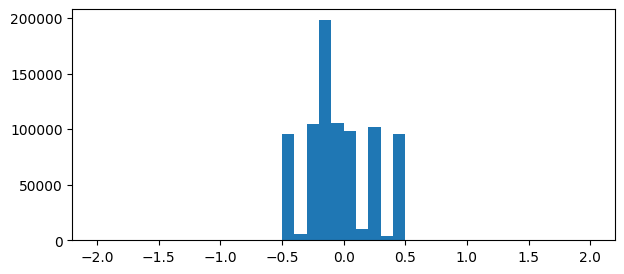

In [26]:
plt.figure(figsize=(7, 3))
plt.hist(Y_compress.ravel(), bins=np.arange(-2, 2.1, 0.1));

## Plot examples

In [11]:
model_ = vqvae_trainer.vqvae
Y_pred = model_.predict(Y_valid)

4/4 [==============================] - 2s 124ms/step


In [12]:
du.mean_absolute_error(Y_valid, Y_pred)

0.00992935308587241

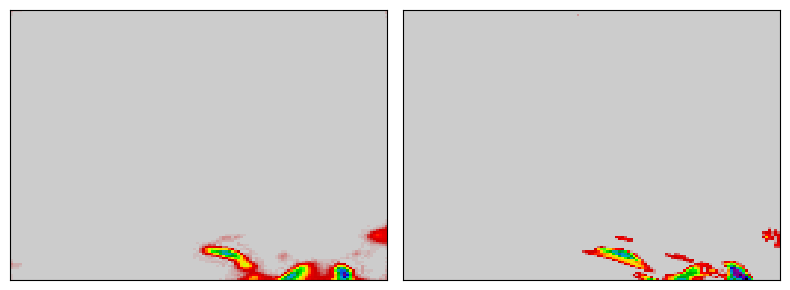

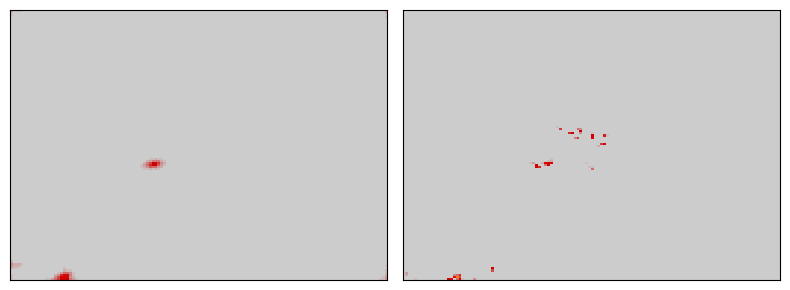

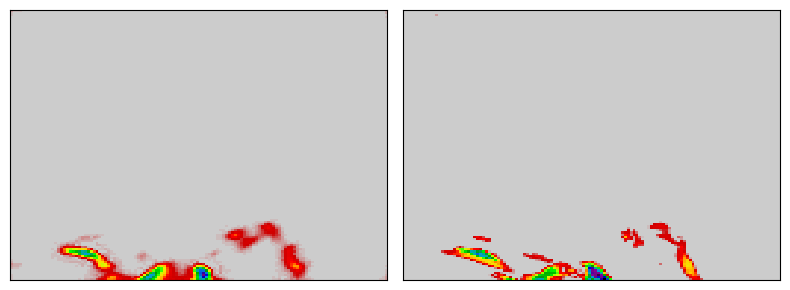

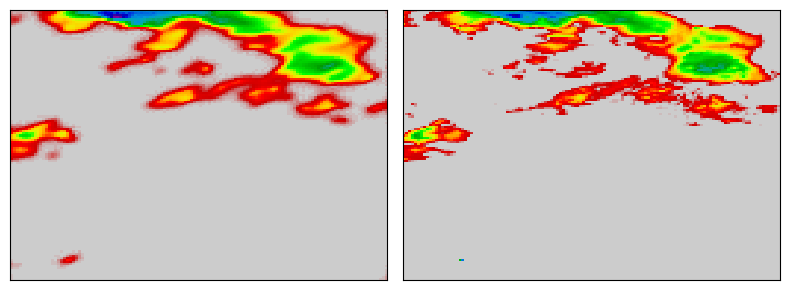

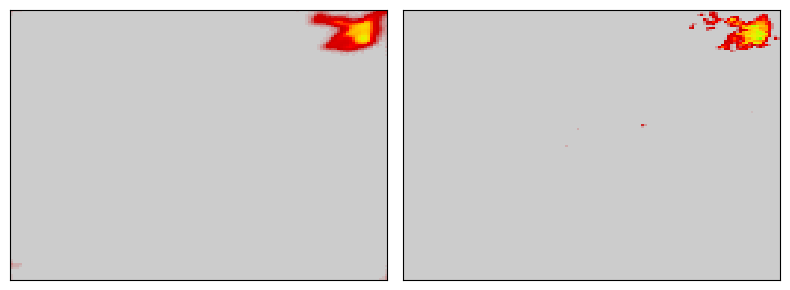

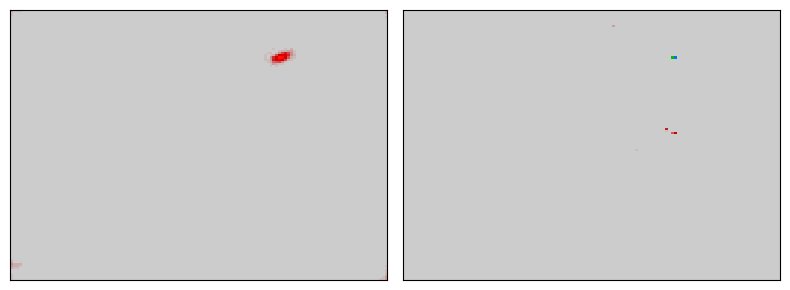

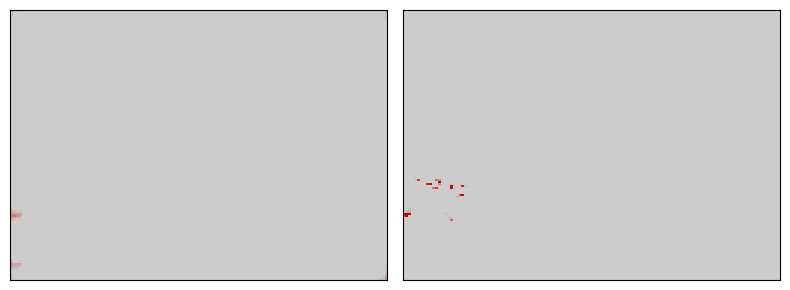

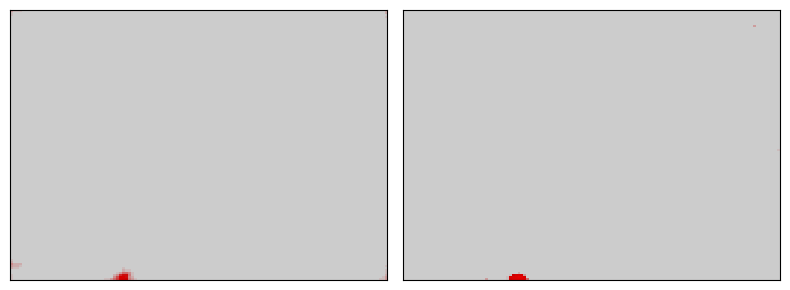

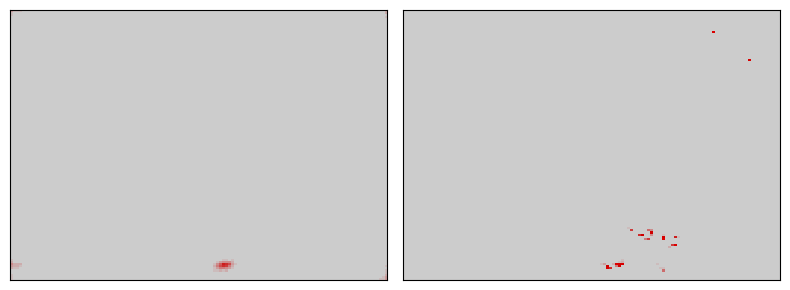

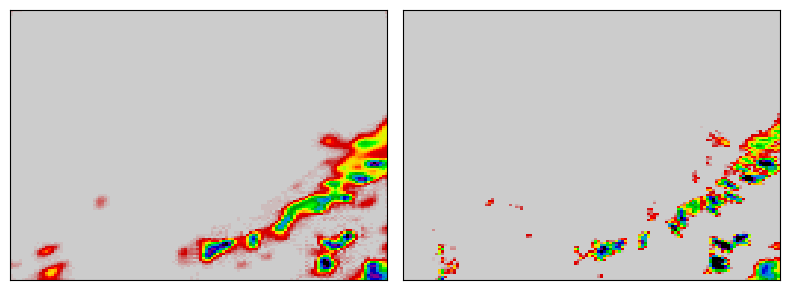

In [13]:
for i in range(10):

    fig, AX = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)